In [1]:
using Flux
using Images, ImageView
using Metalhead
using DataAugmentation #https://lorenzoh.github.io/DataAugmentation.jl
using Augmentor # https://evizero.github.io/Augmentor.jl/
using ImageShow

Gtk-Message: 17:08:21.758: Failed to load module "canberra-gtk-module"
Gtk-Message: 17:08:21.758: Failed to load module "canberra-gtk-module"


In [97]:
fork_train_img_paths = readdir(abspath(joinpath( "ForkSpoonImages" , "Train" , "Forks" )), join = true )
fork_test_img_paths = readdir(abspath(joinpath( "ForkSpoonImages" , "Test" , "Forks" )), join = true )

spoon_train_img_paths = readdir(abspath(joinpath( "ForkSpoonImages" , "Train" , "Spoons" )), join = true )
spoon_test_img_paths = readdir(abspath(joinpath( "ForkSpoonImages" , "Test" , "Spoons" )), join = true )

2-element Vector{String}:
 "/home/tasty/Documents/repos/Jul" ⋯ 47 bytes ⋯ "nImages/Test/Spoons/spoon1.jpeg"
 "/home/tasty/Documents/repos/Jul" ⋯ 46 bytes ⋯ "onImages/Test/Spoons/spoon2.jpg"

In [98]:
#image size for our dimensions
const img_size = ( 224 , 224 )

(224, 224)

In [99]:
#image normalization
const mu = [0.485f0, 0.456f0, 0.406f0] #mean color value
const sigma = [0.229f0, 0.224f0, 0.225f0]; #std of the colors

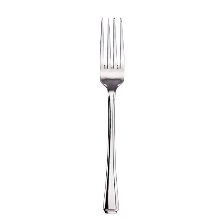

In [100]:
#resize the images to the target size 'Augmentor'
resizer_obj1 = Resize( img_size )

augment( load( fork_train_img_paths[1] ) , resizer_obj1 )

In [104]:
println( size( load( fork_train_img_paths[1] ) ) )
size( augment( load( fork_train_img_paths[1] ) , resizer_obj1 ) )

(764, 764)


(224, 224)

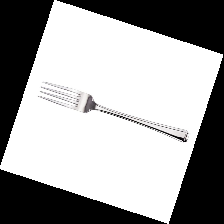

In [108]:
#using 'DataAugmentation'
transform_obj2 = DataAugmentation.compose( Maybe(DataAugmentation.Rotate( round(rand()*60 ) )),Maybe(DataAugmentation.Reflect( round(rand()*60 ) )),
                                Maybe(DataAugmentation.FlipY()),Maybe(DataAugmentation.FlipX()),
                                ScaleKeepAspect(img_size), CenterCrop(img_size));

img_loaded_tmp = Images.load( fork_train_img_paths[1] )
img_transformed_tmp = itemdata( apply( transform_obj2 , Image(img_loaded_tmp) ) )

In [109]:
img = collect(channelview(float32.(RGB.( img_transformed_tmp )))) #dims are CxHxW
img = permutedims((img .- mu) ./ sigma, (3, 2, 1)); #normalize pixel color values and make the dims WHC

In [110]:
size( img )

(224, 224, 3)

In [111]:
training_batch_size = 100
training_labels = []

training_images = zeros( Float32 , img_size[1], img_size[2], 3 , training_batch_size );
size( training_images )

(224, 224, 3, 100)

In [112]:
#return the img (possibly transformed) and the label
function GetTrainingImageAndLabel( utensil_type )
    transform_obj_tmp = DataAugmentation.compose( Maybe(DataAugmentation.Rotate( round(1+rand()*40 ) )),Maybe(DataAugmentation.Reflect( 1+round(rand()*40 ) )),
                                Maybe(DataAugmentation.FlipY()),Maybe(DataAugmentation.FlipX()),
                                ScaleKeepAspect(img_size), CenterCrop(img_size));
    img_loaded_tmp = []
    if( utensil_type == "fork" ) #get fork img
        img_loaded_tmp = Images.load( rand(fork_train_img_paths) )
    elseif( utensil_type == "spoon" ) #get fork img
        img_loaded_tmp = Images.load( rand(spoon_train_img_paths) )
    end
    img_transformed_tmp = itemdata( apply( transform_obj_tmp , Image(img_loaded_tmp) ) )
    img = collect(channelview(float32.(RGB.( img_transformed_tmp )))) #dims are CxHxW
    img = permutedims((img .- mu) ./ sigma, (3, 2, 1)); #normalize pixel color values and make the dims WHC    
    return img
end
size( GetTrainingImageAndLabel( "fork" ) )

(224, 224, 3)

In [113]:
for i in 1:size(training_images)[4]
    utensil_type = rand() > 0.5 ? "fork" : "spoon"
    training_images[:,:,:,i] = GetTrainingImageAndLabel( utensil_type )
    push!( training_labels , utensil_type )
end

In [114]:
println( training_labels[1:10] )

Any["spoon", "fork", "fork", "fork", "fork", "fork", "spoon", "spoon", "fork", "fork"]


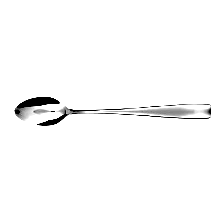

In [115]:
#view an image
colorview( Gray ,  training_images[:,:,1,1]  )

In [116]:
#Load a pre-trained model: ResNet
m_resnet = Metalhead.ResNet(18, pretrain = true).layers

Chain(
  Chain([
    Conv((7, 7), 3 => 64, pad=3, stride=2, bias=false),  # 9_408 parameters
    BatchNorm(64, relu),                # 128 parameters, plus 128
    MaxPool((3, 3), pad=1, stride=2),
    Parallel(
      Metalhead.addrelu,
      Chain(
        Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
        BatchNorm(64, relu),            # 128 parameters, plus 128
        Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
        BatchNorm(64),                  # 128 parameters, plus 128
      ),
      identity,
    ),
    Parallel(
      Metalhead.addrelu,
      Chain(
        Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
        BatchNorm(64, relu),            # 128 parameters, plus 128
        Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
        BatchNorm(64),                  # 128 parameters, plus 128
      ),
      identity,
    ),
    Parallel(
      Metalhead.addrelu,
      Chain(
        Conv((3, 3), 64 =>

In [117]:
#use resnet on some training images, produces a value for each class label 1K ( https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a )
m_resnet( training_images[:,:,:,1:3] )

1000×3 Matrix{Float32}:
 -1.07404    -1.96053    -4.01918
 -1.82217    -3.05838    -1.86811
 -1.31304    -0.90745    -1.56907
 -1.69011    -1.8644     -0.521217
 -2.10795    -1.48786    -0.0622375
  1.5303      0.146204    1.17627
  1.1544     -0.0255158   0.901258
 -1.71675    -2.24538    -1.72083
 -3.61064    -2.86978    -2.96903
  2.57234    -2.50376    -3.88365
  0.0586223  -1.44659    -2.31773
  1.13218    -1.10515    -1.89393
  1.52294    -0.749513   -1.4895
  ⋮                      
 -0.921467   -1.50341    -1.13893
  0.0292915  -2.10376    -1.79749
 -0.449089   -0.852583    0.225928
 -1.30481    -1.37404    -2.75632
 -1.75856    -3.38171    -4.54632
 -4.57314    -3.82775    -5.35908
  0.549907   -1.33779    -2.03965
 -2.11269    -0.909815   -2.47743
 -1.79616    -1.85498    -2.92564
 -2.36086    -2.25742    -3.37302
  0.73819    -0.201409   -9.18582f-5
  2.26738     1.82547     3.90186

In [118]:
#layer number
length( m_resnet )

2

In [119]:
#get the size of the output pre-output label mapping
size( m_resnet[1]( training_images[:,:,:,1:3] ) )

(7, 7, 512, 3)

In [120]:
m_new_layer = Chain( AdaptiveMeanPool((1, 1)) , Flux.flatten , Dense(512 => 2) )

Chain(
  AdaptiveMeanPool((1, 1)),
  Flux.flatten,
  Dense(512 => 2),                      # 1_026 parameters
) 

In [121]:
println( training_labels[1:3] )
resnet_output_tmp = m_resnet[1]( training_images[:,:,:,1:3] )
m_new_layer( resnet_output_tmp )

Any["spoon", "fork", "fork"]


2×3 Matrix{Float32}:
 -1.43043  -1.23724   -0.836774
 -1.11375   0.479072   0.164952

In [122]:
dtrain = Flux.DataLoader( (data=training_images, label=training_labels) , batchsize=20 , shuffle=true );

In [123]:
opt = Flux.setup( Flux.Optimisers.Adam(0.001) , m_new_layer );

In [124]:
Flux.onehotbatch( training_labels , ["fork","spoon"] )

2×100 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  1  1  1  1  ⋅  ⋅  1  1  1  ⋅  1  …  ⋅  1  ⋅  1  ⋅  1  1  ⋅  1  1  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  1  ⋅     1  ⋅  1  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  ⋅

In [132]:
#train the new layer which wraps the first resnet layer
for epoch in 1:10
    for (x, y) in dtrain
        resnet_output_tmp = m_resnet[1]( x )

        grads = gradient( m_new_layer ) do m

            Flux.Losses.logitcrossentropy( m( resnet_output_tmp ) , Flux.onehotbatch( y , ["fork","spoon"] ) )

        end

        Flux.update!(opt, m_new_layer, grads[1])

    end
end

In [133]:
#see how the trained network does on the training data post training
println( training_labels[1:100] )
println( Flux.onecold( Flux.onehotbatch(  training_labels[1:100] , ["fork","spoon"] ) ) )

resnet_output_tmp = m_resnet[1]( training_images[:,:,:,1:100] )

println( Flux.onecold( m_new_layer(resnet_output_tmp) ) )

sum( Flux.onecold( m_new_layer(resnet_output_tmp) ) .== Flux.onecold( Flux.onehotbatch(  training_labels[1:100] , ["fork","spoon"] ) ) ) / 100

Any["spoon", "fork", "fork", "fork", "fork", "fork", "spoon", "spoon", "fork", "fork", "fork", "spoon", "fork", "fork", "spoon", "spoon", "fork", "fork", "spoon", "spoon", "spoon", "fork", "fork", "fork", "fork", "fork", "fork", "spoon", "spoon", "spoon", "spoon", "fork", "fork", "spoon", "spoon", "fork", "fork", "fork", "fork", "fork", "fork", "spoon", "fork", "fork", "spoon", "fork", "fork", "fork", "spoon", "fork", "fork", "fork", "spoon", "spoon", "fork", "spoon", "fork", "fork", "spoon", "fork", "fork", "fork", "fork", "fork", "fork", "fork", "spoon", "spoon", "spoon", "spoon", "fork", "spoon", "spoon", "fork", "fork", "spoon", "fork", "fork", "spoon", "spoon", "fork", "spoon", "spoon", "spoon", "fork", "fork", "fork", "spoon", "spoon", "fork", "spoon", "fork", "spoon", "fork", "fork", "spoon", "fork", "fork", "spoon", "fork"]
[2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,

1.0

In [134]:
#now some testing

In [135]:
testing_batch_size = 20
testing_labels = []

testing_images = zeros( Float32 , img_size[1], img_size[2], 3 , testing_batch_size );
size( testing_images )

(224, 224, 3, 20)

In [136]:
#return the img (possibly transformed) and the label for 'testing'
function GetTestingImageAndLabel( utensil_type )
    transform_obj_tmp = DataAugmentation.compose( Maybe(DataAugmentation.Rotate( round(1+rand()*40 ) )),Maybe(DataAugmentation.Reflect( 1+round(rand()*40 ) )),
                                Maybe(DataAugmentation.FlipY()),Maybe(DataAugmentation.FlipX()),
                                ScaleKeepAspect(img_size), CenterCrop(img_size));
    img_loaded_tmp = []
    if( utensil_type == "fork" ) #get fork img from testing
        img_loaded_tmp = Images.load( rand(fork_test_img_paths) )
    elseif( utensil_type == "spoon" ) #get fork img from testing
        img_loaded_tmp = Images.load( rand(spoon_test_img_paths) )
    end
    img_transformed_tmp = itemdata( apply( transform_obj_tmp , Image(img_loaded_tmp) ) )
    img = collect(channelview(float32.(RGB.( img_transformed_tmp )))) #dims are CxHxW
    img = permutedims((img .- mu) ./ sigma, (3, 2, 1)); #normalize pixel color values and make the dims WHC    
    return img
end
size( GetTestingImageAndLabel( "fork" ) )

(224, 224, 3)

In [137]:
for i in 1:size(testing_images)[4]
    utensil_type = rand() > 0.5 ? "fork" : "spoon"
    testing_images[:,:,:,i] = GetTestingImageAndLabel( utensil_type )
    push!( testing_labels , utensil_type )
end

In [138]:
#see how the trained network does on the 'testing' 
println( testing_labels )
println( Flux.onecold( Flux.onehotbatch(  testing_labels , ["fork","spoon"] ) ) )

resnet_output_tmp = m_resnet[1]( testing_images )

println( Flux.onecold( m_new_layer(resnet_output_tmp) ) )

accuracy = sum( Flux.onecold( m_new_layer(resnet_output_tmp) ) .== Flux.onecold( Flux.onehotbatch( testing_labels , ["fork","spoon"] ) ) ) / length(testing_labels)
println("testing label accuracy = $(accuracy*100)%")

Any["fork", "fork", "spoon", "spoon", "spoon", "fork", "fork", "fork", "fork", "spoon", "fork", "fork", "fork", "fork", "spoon", "fork", "fork", "spoon", "spoon", "fork"]
[1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1]
[1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1]
testing label accuracy = 90.0%
